<a href="https://colab.research.google.com/github/AyberkMunis/airline_customer_satisfaction_project/blob/main/airline_customer_statisfaction_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Business Problem**

The Airline industry suffered a huge setback after the pandemic, and as per ICAO, the airline industry suffered a 371 bn loss in 2020, and 329 bn with the reduced seat capacity. Hence, to revive the industry in the light of this recession, it is absolutely a necessity to understand the customer pain points, and improve their satisfaction in the services provided.

In this project, our aim is to develop a model that predicts whether customers are satisfied or dissatisfied and identify the reasons for dissatisfaction, in order to contribute to the airline company



# **Variables**


Gender: Gender of the passengers (Female, Male)

Customer Type: The customer type (Loyal customer, disloyal customer)

Age: The actual age of the passengers

Type of Travel: Purpose of the flight of the passengers (Personal Travel, Business Travel)

Class: Travel class in the plane of the passengers (Business, Eco, Eco Plus)

Flight distance: The flight distance of this journey

Inflight wifi service: Satisfaction level of the inflight wifi service (0:Not Applicable;1-5)

Departure/Arrival time convenient: Satisfaction level of Departure/Arrival time convenient

Ease of Online booking: Satisfaction level of online booking

Gate location: Satisfaction level of Gate location

Food and drink: Satisfaction level of Food and drink

Online boarding: Satisfaction level of online boarding

Seat comfort: Satisfaction level of Seat comfort

Inflight entertainment: Satisfaction level of inflight entertainment

On-board service: Satisfaction level of On-board service

Leg room service: Satisfaction level of Leg room service

Baggage handling: Satisfaction level of baggage handling

Check-in service: Satisfaction level of Check-in service

Inflight service: Satisfaction level of inflight service

Cleanliness: Satisfaction level of Cleanliness

Departure Delay in Minutes: Minutes delayed when departure

Arrival Delay in Minutes: Minutes delayed when Arrival

Satisfaction: Airline satisfaction level(Satisfaction, neutral or dissatisfaction)

# **Imports And Needed Funcitons**

In [ ]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

#!pip install catboost
#!pip install lightgbm
#!pip install xgboost

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [ ]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()
    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)
    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns
    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")

def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

def correlation_matrix(df, cols):
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={'size': 12}, linecolor='w', cmap='RdBu')
    plt.show(block=True)

def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    # print(f"Observations: {dataframe.shape[0]}")
    # print(f"Variables: {dataframe.shape[1]}")
    # print(f'cat_cols: {len(cat_cols)}')
    # print(f'num_cols: {len(num_cols)}')
    # print(f'cat_but_car: {len(cat_but_car)}')
    # print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

def check_outlier(dataframe, col_name, q1=0.25, q3=0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
                   ('LightGBM', LGBMClassifier()),
                   # ('CatBoost', CatBoostClassifier(verbose=False))
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

def hyperparameter_optimization(X, y, cv=3, scoring="roc_auc"):
    print("Hyperparameter Optimization....")
    best_models = {}
    for name, classifier, params in classifiers:
        print(f"########## {name} ##########")
        cv_results = cross_validate(classifier, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")

        gs_best = GridSearchCV(classifier, params, cv=cv, n_jobs=-1, verbose=False).fit(X, y)
        final_model = classifier.set_params(**gs_best.best_params_)

        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (After): {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model
    return best_models

def voting_classifier(best_models, X, y):
    print("Voting Classifier...")

    voting_clf = VotingClassifier(estimators=[('KNN', best_models["KNN"]),
                                              ('RF', best_models["RF"]),
                                              ('LightGBM', best_models["LightGBM"])],
                                  voting='soft').fit(X, y)

    cv_results = cross_validate(voting_clf, X, y, cv=3, scoring=["accuracy", "f1", "roc_auc"])
    print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
    print(f"F1Score: {cv_results['test_f1'].mean()}")
    print(f"ROC_AUC: {cv_results['test_roc_auc'].mean()}")
    return voting_clf

def plot_importance(model,features, num, save=False,name="importance"):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig(f'{name}.png')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

df = pd.read_csv("/kaggle/input/airline-passenger-satisfaction/train.csv")

# **Explorative Data Analysis**

In [ ]:
check_df(df)

##################### Shape #####################
(103904, 25)
##################### Types #####################
Unnamed: 0                             int64
id                                     int64
Gender                                object
Customer Type                         object
Age                                    int64
Type of Travel                        object
Class                                 object
Flight Distance                        int64
Inflight wifi service                  int64
Departure/Arrival time convenient      int64
Ease of Online booking                 int64
Gate location                          int64
Food and drink                         int64
Online boarding                        int64
Seat comfort                           int64
Inflight entertainment                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                 

/tmp/ipykernel_32/3735826105.py:31: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


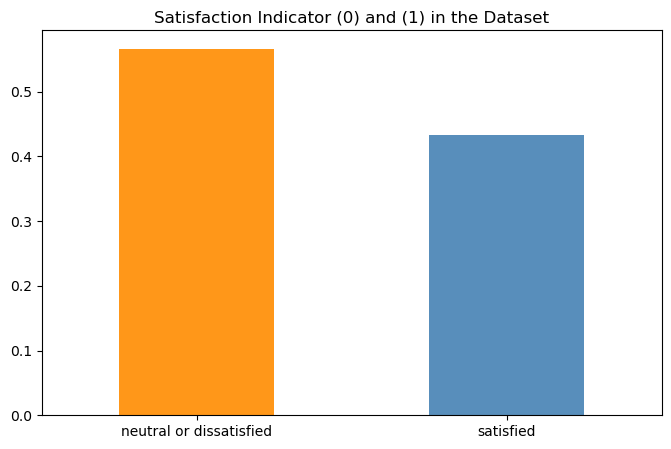

In [ ]:
fig = plt.figure(figsize=(8, 5))
df.satisfaction.value_counts(normalize=True).plot(kind='bar', color=['darkorange', 'steelblue'], alpha=0.9, rot=0)
plt.title('Satisfaction Indicator (0) and (1) in the Dataset')
plt.show(block="True")

In [ ]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

# Categorical Variable Analysis

In [ ]:
for col in cat_cols:
    cat_summary(df, col)

        Gender      Ratio
Female   52727  50.745881
Male     51177  49.254119
##########################################
                   Customer Type      Ratio
Loyal Customer             84923  81.732176
disloyal Customer          18981  18.267824
##########################################
                 Type of Travel      Ratio
Business travel           71655  68.962696
Personal Travel           32249  31.037304
##########################################
          Class      Ratio
Business  49665  47.798930
Eco       46745  44.988643
Eco Plus   7494   7.212427
##########################################
                         satisfaction      Ratio
neutral or dissatisfied         58879  56.666731
satisfied                       45025  43.333269
##########################################
   Inflight wifi service      Ratio
3                  25868  24.896058
2                  25830  24.859486
4                  19794  19.050277
1                  17840  17.169695
5          

# Numeric Variable Analysis

count    103904.000000
mean      51951.500000
std       29994.645522
min           0.000000
5%         5195.150000
10%       10390.300000
20%       20780.600000
30%       31170.900000
40%       41561.200000
50%       51951.500000
60%       62341.800000
70%       72732.100000
80%       83122.400000
90%       93512.700000
95%       98707.850000
99%      102863.970000
max      103903.000000
Name: Unnamed: 0, dtype: float64


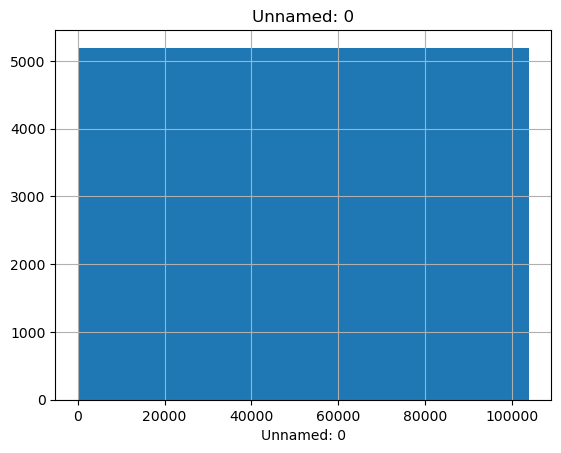

count    103904.000000
mean      64924.210502
std       37463.812252
min           1.000000
5%         6593.150000
10%       13044.300000
20%       26084.200000
30%       38973.900000
40%       51909.200000
50%       64856.500000
60%       77837.800000
70%       90848.300000
80%      103894.400000
90%      116883.700000
95%      123409.700000
99%      128588.970000
max      129880.000000
Name: id, dtype: float64


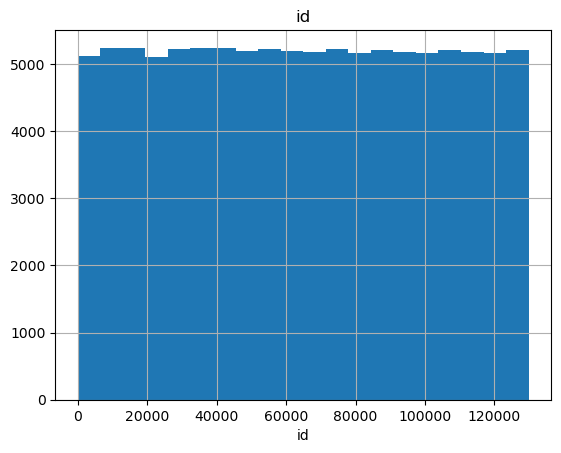

count    103904.000000
mean         39.379706
std          15.114964
min           7.000000
5%           14.000000
10%          20.000000
20%          25.000000
30%          30.000000
40%          36.000000
50%          40.000000
60%          44.000000
70%          48.000000
80%          53.000000
90%          59.000000
95%          64.000000
99%          70.000000
max          85.000000
Name: Age, dtype: float64


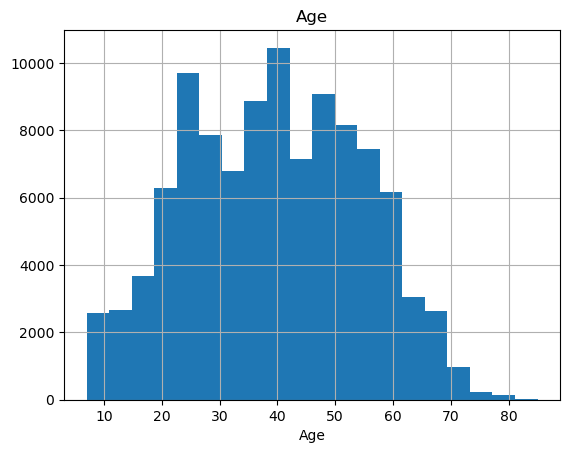

count    103904.000000
mean       1189.448375
std         997.147281
min          31.000000
5%          175.000000
10%         236.000000
20%         358.000000
30%         482.000000
40%         630.000000
50%         843.000000
60%        1050.000000
70%        1513.000000
80%        2065.000000
90%        2750.000000
95%        3383.000000
99%        3882.000000
max        4983.000000
Name: Flight Distance, dtype: float64


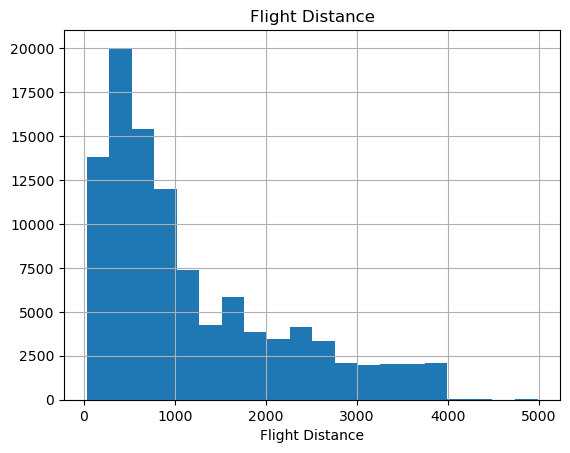

count    103904.000000
mean         14.815618
std          38.230901
min           0.000000
5%            0.000000
10%           0.000000
20%           0.000000
30%           0.000000
40%           0.000000
50%           0.000000
60%           2.000000
70%           8.000000
80%          19.000000
90%          44.000000
95%          78.000000
99%         181.970000
max        1592.000000
Name: Departure Delay in Minutes, dtype: float64


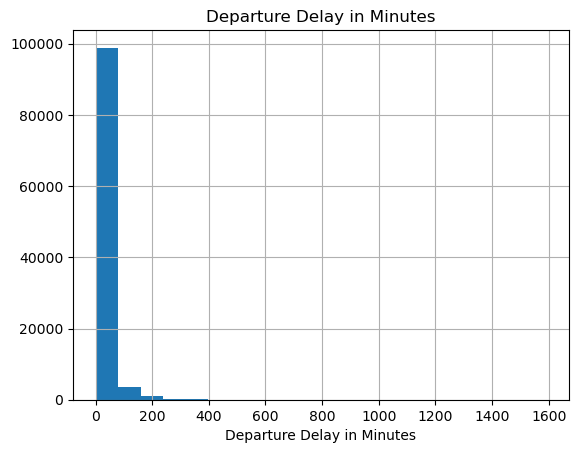

count    103594.000000
mean         15.178678
std          38.698682
min           0.000000
5%            0.000000
10%           0.000000
20%           0.000000
30%           0.000000
40%           0.000000
50%           0.000000
60%           2.000000
70%           9.000000
80%          19.000000
90%          44.000000
95%          79.000000
99%         184.000000
max        1584.000000
Name: Arrival Delay in Minutes, dtype: float64


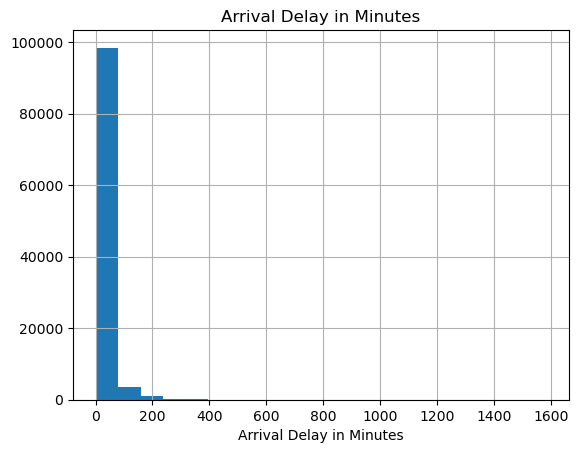

In [ ]:
for col in num_cols:
    num_summary(df, col, plot=True)


In [ ]:
for col in num_cols:
    target_summary_with_num(df, "satisfaction", col)

                           Unnamed: 0
satisfaction                         
neutral or dissatisfied  52075.578746
satisfied                51789.242754


                                   id
satisfaction                         
neutral or dissatisfied  64474.259176
satisfied                65512.609928


                               Age
satisfaction                      
neutral or dissatisfied  37.566688
satisfied                41.750583


                         Flight Distance
satisfaction                            
neutral or dissatisfied       928.919971
satisfied                    1530.140255


                         Departure Delay in Minutes
satisfaction                                       
neutral or dissatisfied                   16.503728
satisfied                                 12.608084


                         Arrival Delay in Minutes
satisfaction                                     
neutral or dissatisfied                 17.127536
satisfied               

# Missing Value Analaysis

In [ ]:
df.isnull().sum()
na_columns = missing_values_table(df, na_name=True)

                          n_miss  ratio
Arrival Delay in Minutes     310    0.3


# Correlation Analaysis

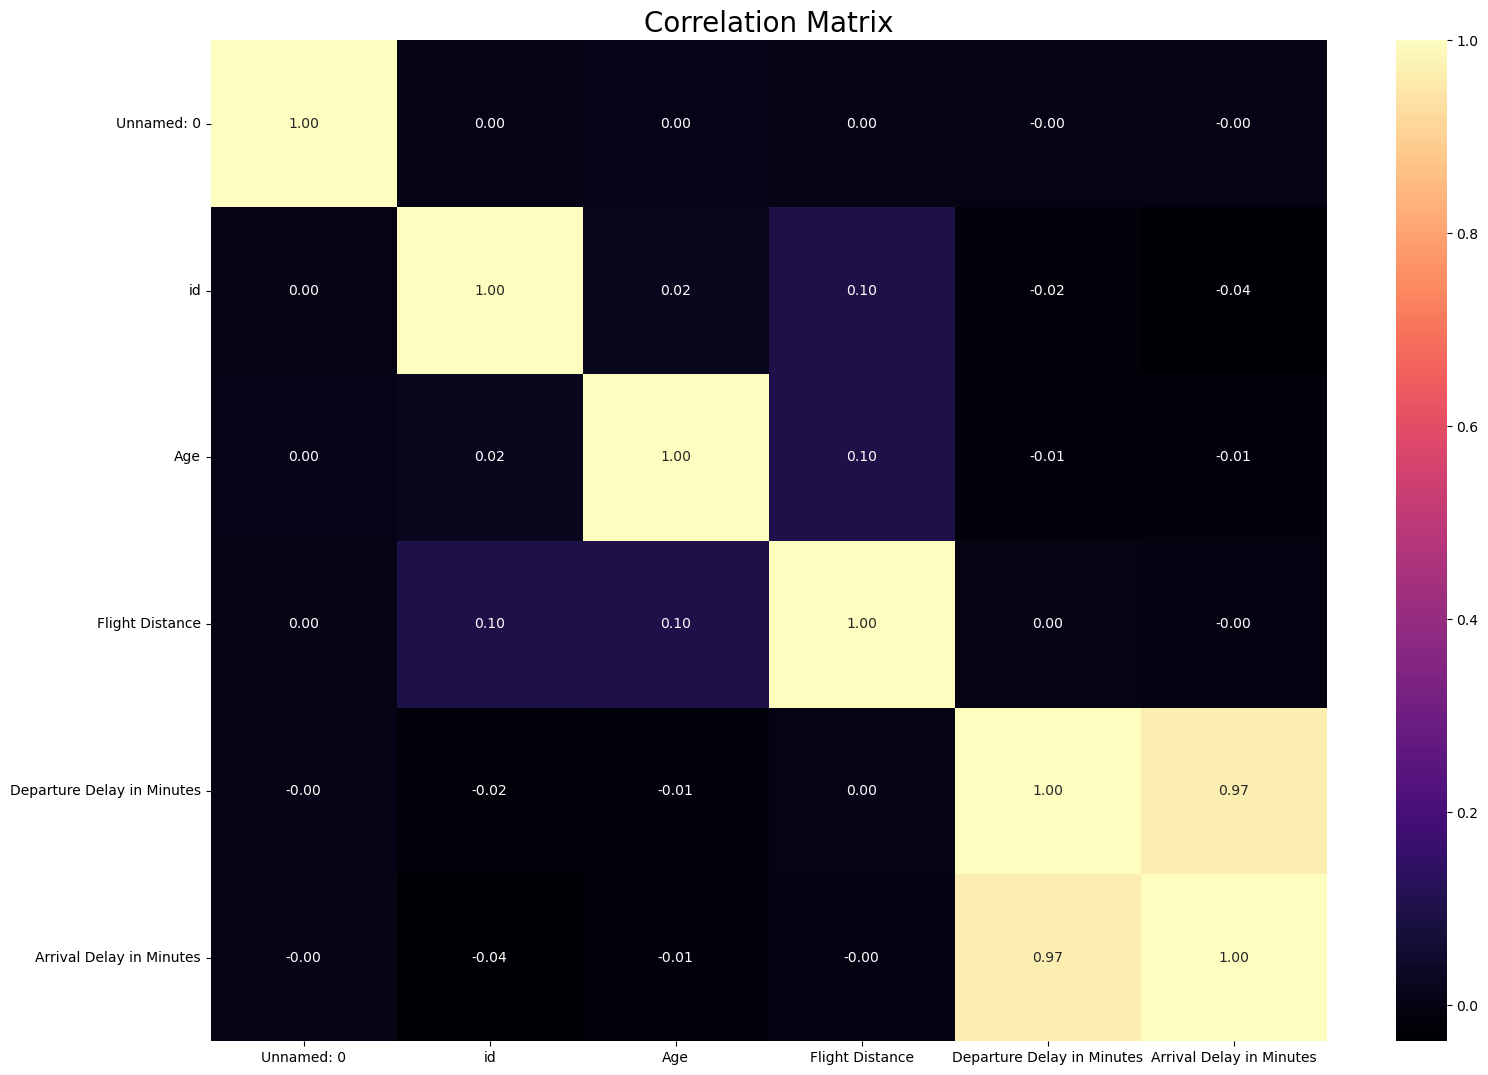

In [ ]:
df[num_cols].corr()

# Korelasyon Matrisi
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show(block="True")




# **Feature Engineering**

In [ ]:
##################################
# Before start, Dropping unnecessary variables, column names update, classify variables and separate target variable
##################################

df = df.drop("id", axis=1)
df = df.drop("Unnamed: 0", axis=1) # We don't need those variables.

df.columns = [col.upper() for col in df.columns]

cat_cols, num_cols, cat_but_car = grab_col_names(df)

cat_cols = [col for col in cat_cols if col not in ["SATISFACTION"]] # Satisfaciton is our target value.

In [ ]:
##################################
# Missing value analysis
##################################

df.isnull().sum()

GENDER                                 0
CUSTOMER TYPE                          0
AGE                                    0
TYPE OF TRAVEL                         0
CLASS                                  0
FLIGHT DISTANCE                        0
INFLIGHT WIFI SERVICE                  0
DEPARTURE/ARRIVAL TIME CONVENIENT      0
EASE OF ONLINE BOOKING                 0
GATE LOCATION                          0
FOOD AND DRINK                         0
ONLINE BOARDING                        0
SEAT COMFORT                           0
INFLIGHT ENTERTAINMENT                 0
ON-BOARD SERVICE                       0
LEG ROOM SERVICE                       0
BAGGAGE HANDLING                       0
CHECKIN SERVICE                        0
INFLIGHT SERVICE                       0
CLEANLINESS                            0
DEPARTURE DELAY IN MINUTES             0
ARRIVAL DELAY IN MINUTES             310
SATISFACTION                           0
dtype: int64

In [ ]:
missing_values_table(df)
na_cols = missing_values_table(df, na_name=True)

                          n_miss  ratio
ARRIVAL DELAY IN MINUTES     310    0.3
                          n_miss  ratio
ARRIVAL DELAY IN MINUTES     310    0.3


In [ ]:
# missing_vs_target(df, "satisfaction", na_cols)
# The function does not work for now because "satisfaction" is not in a standardized state

df = label_encoder(df, "SATISFACTION") ###  ! (1: satisfaction) & (0: neutral or dissatisfied)

missing_vs_target(df, "SATISFACTION", na_cols)

                                  TARGET_MEAN   Count
ARRIVAL DELAY IN MINUTES_NA_FLAG                     
0                                    0.433394  103594
1                                    0.412903     310




In [ ]:
##################################
# Filling Missing value
##################################

# Since there is a linear relationship between 'Arrival time' & 'Departure Time', and only a few missing values exist, I have chosen to fill the missing values with the corresponding 'Departure Time' values in order to preserve the linear relationship.
df["ARRIVAL DELAY IN MINUTES"].fillna(df["DEPARTURE DELAY IN MINUTES"], inplace=True)

df.isnull().sum()

GENDER                               0
CUSTOMER TYPE                        0
AGE                                  0
TYPE OF TRAVEL                       0
CLASS                                0
FLIGHT DISTANCE                      0
INFLIGHT WIFI SERVICE                0
DEPARTURE/ARRIVAL TIME CONVENIENT    0
EASE OF ONLINE BOOKING               0
GATE LOCATION                        0
FOOD AND DRINK                       0
ONLINE BOARDING                      0
SEAT COMFORT                         0
INFLIGHT ENTERTAINMENT               0
ON-BOARD SERVICE                     0
LEG ROOM SERVICE                     0
BAGGAGE HANDLING                     0
CHECKIN SERVICE                      0
INFLIGHT SERVICE                     0
CLEANLINESS                          0
DEPARTURE DELAY IN MINUTES           0
ARRIVAL DELAY IN MINUTES             0
SATISFACTION                         0
dtype: int64

In [ ]:
##################################
# Outliers Analysis
##################################

for col in num_cols:
    print(col, check_outlier(df, col, q1=0.05, q3=0.95))

for col in  num_cols:
    print(col, check_outlier(df, col, q1=0.05, q3=0.95))
    if check_outlier(df, col):
        replace_with_thresholds(df, col)

for col in num_cols:
    print(col, check_outlier(df, col, q1=0.05, q3=0.95))

AGE False
FLIGHT DISTANCE False
DEPARTURE DELAY IN MINUTES True
ARRIVAL DELAY IN MINUTES True
AGE False
FLIGHT DISTANCE False
DEPARTURE DELAY IN MINUTES True
ARRIVAL DELAY IN MINUTES True
AGE False
FLIGHT DISTANCE False
DEPARTURE DELAY IN MINUTES False
ARRIVAL DELAY IN MINUTES False


In [ ]:
##################################
# Outliers Analysis
##################################

for col in num_cols:
    print(col, check_outlier(df, col, q1=0.05, q3=0.95))

for col in  num_cols:
    print(col, check_outlier(df, col, q1=0.05, q3=0.95))
    if check_outlier(df, col):
        replace_with_thresholds(df, col)

for col in num_cols:
    print(col, check_outlier(df, col, q1=0.05, q3=0.95))

AGE False
FLIGHT DISTANCE False
DEPARTURE DELAY IN MINUTES False
ARRIVAL DELAY IN MINUTES False
AGE False
FLIGHT DISTANCE False
DEPARTURE DELAY IN MINUTES False
ARRIVAL DELAY IN MINUTES False
AGE False
FLIGHT DISTANCE False
DEPARTURE DELAY IN MINUTES False
ARRIVAL DELAY IN MINUTES False


In [ ]:
##################################
# Feature extraction
##################################

df.loc[(df["AGE"] < 18), "NEW_AGE_CAT"] = "Child"
df.loc[(df["AGE"] >= 18) & (df["AGE"] < 35), "NEW_AGE_CAT"] = "mature"
df.loc[(df["AGE"] >= 35) & (df["AGE"] < 50), "NEW_AGE_CAT"] = "Senior"
df.loc[(df["AGE"] >= 50), "NEW_AGE_CAT"] = "Old"

# Industry Standards: short distance: x < 1000 km, middle distance: 1000 km < x < 3000 km, long distance x > 3000 km
df.loc[(df["FLIGHT DISTANCE"] < 1000), "NEW_FLIGHT_DISTANCE_CAT"] = "Short_distance"
df.loc[(df["FLIGHT DISTANCE"] >= 1000) & (df["AGE"] < 3000), "NEW_FLIGHT_DISTANCE_CAT"] = "Middle_distance"
df.loc[(df["FLIGHT DISTANCE"] >= 3000), "NEW_FLIGHT_DISTANCE_CAT"] = "Long_distance"

df["NEW_TOTAL_SERVICE_AVG"] = df[["INFLIGHT WIFI SERVICE", "FOOD AND DRINK", "INFLIGHT ENTERTAINMENT", "INFLIGHT SERVICE", "ON-BOARD SERVICE"]].mean(axis=1)

df["NEW_TOTAL_COMFORT_AVG"] = df[["SEAT COMFORT", "LEG ROOM SERVICE", "CLEANLINESS"]].mean(axis=1)

df["NEW_TOTAL_OUTSIDEPLANE_AVG"] = df[["EASE OF ONLINE BOOKING", "GATE LOCATION", "ONLINE BOARDING", "BAGGAGE HANDLING", "CHECKIN SERVICE"]].mean(axis=1)

df["NEW_TOTAL_DELAY"] = df[["DEPARTURE DELAY IN MINUTES", "ARRIVAL DELAY IN MINUTES"]].sum(axis=1)

df["NEW_GENDER_PLUS_TRAVEL"] = df["GENDER"] + "-" + df["TYPE OF TRAVEL"]

# We created new variables so we need to use grap_col_ names again

cat_cols, num_cols, cat_but_car = grab_col_names(df)

In [ ]:
##################################
# Encoding
##################################

binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]

for col in binary_cols:
    df = label_encoder(df, col)

# Update cat_cols

cat_cols = [col for col in cat_cols if df[col].dtypes == "O"]

df = one_hot_encoder(df, cat_cols, drop_first=True)

In [ ]:
##################################
# STANDARDIZATION
##################################

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [ ]:
def airline_data_prep(dataframe):
    dataframe = dataframe.drop("id", axis=1)
    dataframe = dataframe.drop("Unnamed: 0", axis=1)  # We don't need those variables.

    dataframe.columns = [col.upper() for col in dataframe.columns]

    cat_cols, num_cols, cat_but_car = grab_col_names(dataframe)

    cat_cols = [col for col in cat_cols if col not in ["SATISFACTION"]]  # Satisfaciton is our target value.

    dataframe = label_encoder(dataframe, "SATISFACTION")  ###  ! (1: satisfaction) & (0: neutral or dissatisfied)

    dataframe["ARRIVAL DELAY IN MINUTES"].fillna(dataframe["DEPARTURE DELAY IN MINUTES"], inplace=True)

    for col in num_cols:

        if check_outlier(dataframe, col):
            replace_with_thresholds(dataframe, col)

    dataframe.loc[(dataframe["AGE"] < 18), "NEW_AGE_CAT"] = "Child"
    dataframe.loc[(dataframe["AGE"] >= 18) & (dataframe["AGE"] < 35), "NEW_AGE_CAT"] = "mature"
    dataframe.loc[(dataframe["AGE"] >= 35) & (dataframe["AGE"] < 50), "NEW_AGE_CAT"] = "Senior"
    dataframe.loc[(dataframe["AGE"] >= 50), "NEW_AGE_CAT"] = "Old"

    # Industry Standards: short distance: x < 1000 km, middle distance: 1000 km < x < 3000 km, long distance x > 3000 km
    dataframe.loc[(dataframe["FLIGHT DISTANCE"] < 1000), "NEW_FLIGHT_DISTANCE_CAT"] = "Short_distance"
    dataframe.loc[(dataframe["FLIGHT DISTANCE"] >= 1000) & (dataframe["AGE"] < 3000), "NEW_FLIGHT_DISTANCE_CAT"] = "Middle_distance"
    dataframe.loc[(dataframe["FLIGHT DISTANCE"] >= 3000), "NEW_FLIGHT_DISTANCE_CAT"] = "Long_distance"

    dataframe["NEW_TOTAL_SERVICE_AVG"] = dataframe[["INFLIGHT WIFI SERVICE", "FOOD AND DRINK", "INFLIGHT ENTERTAINMENT", "INFLIGHT SERVICE", "ON-BOARD SERVICE"]].mean(axis=1)

    dataframe["NEW_TOTAL_COMFORT_AVG"] = dataframe[["SEAT COMFORT", "LEG ROOM SERVICE", "CLEANLINESS"]].mean(axis=1)

    dataframe["NEW_TOTAL_OUTSIDEPLANE_AVG"] = dataframe[["EASE OF ONLINE BOOKING", "GATE LOCATION", "ONLINE BOARDING", "BAGGAGE HANDLING", "CHECKIN SERVICE"]].mean(axis=1)

    dataframe["NEW_TOTAL_DELAY"] = dataframe[["DEPARTURE DELAY IN MINUTES", "ARRIVAL DELAY IN MINUTES"]].sum(axis=1)

    dataframe["NEW_GENDER_PLUS_TRAVEL"] = dataframe["GENDER"] + "-" + dataframe["TYPE OF TRAVEL"]

    # We created new variables so we need to use grap_col_ names again

    cat_cols, num_cols, cat_but_car = grab_col_names(dataframe)

    binary_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O" and dataframe[col].nunique() == 2]

    for col in binary_cols:
        dataframe = label_encoder(dataframe, col)

    # Update cat_cols

    cat_cols = [col for col in cat_cols if dataframe[col].dtypes == "O"]

    dataframe = one_hot_encoder(dataframe, cat_cols, drop_first=True)

    scaler = StandardScaler()
    dataframe[num_cols] = scaler.fit_transform(dataframe[num_cols])

    Y = dataframe["SATISFACTION"]
    X = dataframe.drop(["SATISFACTION"], axis=1)

    print("Data Set is ready to use in any model. (X = All variables), (Y = SATISFACTION)")
    return X, Y


# **Modeling**

In [ ]:
###########################################################
##########               Modelling ######
###########################################################

#Base Models are Logistic Regression,KNN, SVC , CART,Random Forest Classifier, Adaboost,Gradient Boost, XGBoost,LightGBM


X, y = airline_data_prep(pd.read_csv("/kaggle/input/airline-passenger-satisfaction/train.csv"))

base_models(X,y,scoring="f1") #Base Model for f1_Scorex


Data Set is ready to use in any model. (X = All variables), (Y = SATISFACTION)
Base Models....


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/pr

f1: 0.8539 (LR) 
f1: 0.9072 (KNN) 
f1: 0.9296 (SVC) 
f1: 0.9325 (CART) 
f1: 0.9505 (RF) 
f1: 0.916 (Adaboost) 
f1: 0.9297 (GBM) 


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


f1: 0.9542 (XGBoost) 
f1: 0.9553 (LightGBM) 


In [ ]:
base_models(X,y,scoring="roc_auc") #creating base_model for roc_auc score

Base Models....


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/pr

roc_auc: 0.9282 (LR) 
roc_auc: 0.9659 (KNN) 
roc_auc: 0.9829 (SVC) 
roc_auc: 0.94 (CART) 
roc_auc: 0.9923 (RF) 
roc_auc: 0.9784 (Adaboost) 
roc_auc: 0.9875 (GBM) 


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


roc_auc: 0.9944 (XGBoost) 
roc_auc: 0.9946 (LightGBM) 


In [ ]:
base_models(X,y,scoring="accuracy") #creating base models for accuracy score

Base Models....


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/pr

accuracy: 0.8758 (LR) 
accuracy: 0.9218 (KNN) 
accuracy: 0.9399 (SVC) 
accuracy: 0.9413 (CART) 
accuracy: 0.9578 (RF) 
accuracy: 0.9276 (Adaboost) 
accuracy: 0.94 (GBM) 


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


accuracy: 0.9609 (XGBoost) 
accuracy: 0.962 (LightGBM) 


In [ ]:
scores={"LR":0.8539 ,"KNN":0.9072,"SVC":0.9296,"CART":0.9323  ,
       "RF":0.9508 ,"Adaboost":0.916  ,"GBM":0.9297 ,"XGBOOST":0.9542
       ,"LightGBM":0.9553 }
scores2={"LR":0.9282,"KNN":0.9659 ,"SVC":0.9829 ,"CART":0.9401 ,
       "RF":0.9924 ,"Adaboost":0.9784 ,"GBM":0.9875 ,"XGBOOST":0.9944
       ,"LightGBM":0.9946}
scores3={"LR":0.8758,"KNN":0.9218,"SVC":0.9399 ,"CART":0.9409 ,
       "RF":0.9576,"Adaboost":0.9276 ,"GBM":0.94 ,"XGBOOST":0.9609
       ,"LightGBM":0.962 }

In [ ]:
list(scores.values())

[0.8539, 0.9072, 0.9296, 0.9323, 0.9508, 0.916, 0.9297, 0.9542, 0.9553]

In [ ]:
x=np.arange(len(scores.keys()))

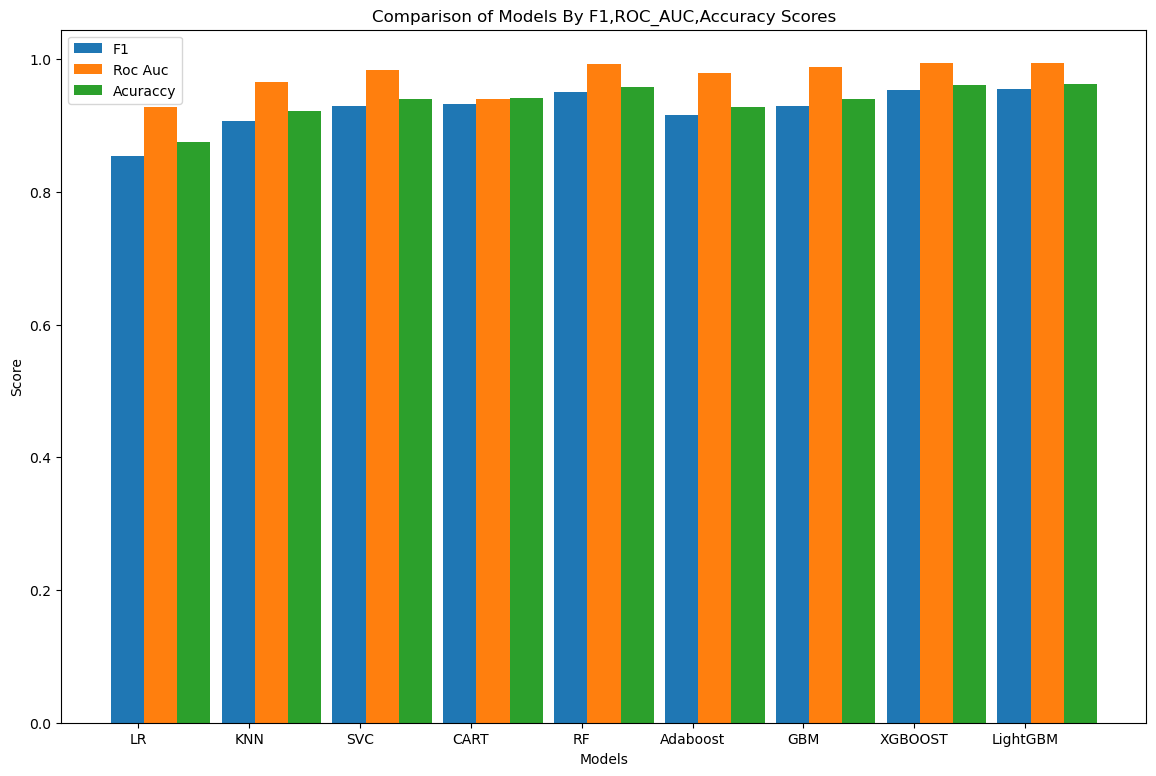

In [ ]:
fig,ax=plt.subplots(figsize=(14,9))
p1=ax.bar(x - 0.3/3,list(scores.values()),0.3,label="F1")
p2=ax.bar(x+2*0.3/3 ,list(scores2.values()),0.3,label="Roc Auc")
p2=ax.bar(x +5*0.3/3,list(scores3.values()),0.3,label="Acuraccy")
ax.set_xticks(x,list(scores.keys()))
ax.set_title("Comparison of Models By F1,ROC_AUC,Accuracy Scores")
ax.set_xlabel("Models")
ax.set_ylabel("Score")
ax.legend()




plt.show()

In [ ]:
# # Focusing on the Models which has Best Performance between Base Models
#     LightGBM
#     XGBOOST


lightgbm=LGBMClassifier()
xgboost=XGBClassifier()

# Hyperparameter Optimization

In [ ]:
###############################
# Hyperparameter Optimization
###############################

#Hyperparameter Optimization for LightGBM
lightgbm_params={"learning_rate":[0.1,0.01,0.5],
                 "max_depth":[5,8,10],
                 "n_estimators":[75,100,500],
                 "colsample_bytree":[None,0.5,0.75,1]}
xg_params={"learning_rate":[0.1,0.01],
           "max_depth":[5,8],
           "n_estimators":[100,500,1000],
           "colsample_bytree":[None,0.5,1]}





In [ ]:
X_test, y_test = airline_data_prep(pd.read_csv("/kaggle/input/airline-passenger-satisfaction/test.csv"))

Data Set is ready to use in any model. (X = All variables), (Y = SATISFACTION)


In [ ]:
#Final Model of LightGBM with best hyperparameters
lightgbm_grid=GridSearchCV(lightgbm,lightgbm_params,cv=2,n_jobs=-1,verbose=1).fit(X_test,y_test) #Hyperparameter Optimization for LightGBM
lightgbm_grid.best_params_
lightgbm_final=lightgbm.set_params(**lightgbm_grid.best_params_)

Fitting 2 folds for each of 108 candidates, totalling 216 fits


In [ ]:
#Final Model of LightGBM with best hyperparameters
xgb_grid=GridSearchCV(xgboost,xg_params,cv=2,n_jobs=-1,verbose=1).fit(X_test,y_test)


Fitting 2 folds for each of 36 candidates, totalling 72 fits


In [ ]:
xgb_final=xgboost.set_params(**xgb_grid.best_params_)


In [ ]:
cv_light=cross_validate(lightgbm_final,X_test,y_test,cv=2,verbose=1,scoring=["f1","roc_auc","accuracy"],n_jobs=-1) #Cross Validation for Fianl Model of LightGbm Made by Test Data

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    9.8s finished


In [ ]:
(cv_light["test_f1"].mean(),cv_light["test_roc_auc"].mean(),cv_light["test_accuracy"].mean()) #F1,Roc_Auc,Accuracy scores for LightGBM

(0.9508815164741093, 0.9930807473760235, 0.9574607329842932)

In [ ]:
cv_xgb=cross_validate(xgb_final,X,y,cv=2,verbose=1,scoring=["f1","roc_auc","accuracy"],n_jobs=-1)#Cross Validation for Fianl Model of XGBoost Made By Test Data

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   24.3s finished


In [ ]:
(cv_xgb["test_f1"].mean(),cv_xgb["test_roc_auc"].mean(),cv_xgb["test_accuracy"].mean()) #F1,Roc_Auc,Accuracy scores for XGBoost

(0.9532331323576159, 0.993876838445904, 0.9601747767169695)

In [ ]:
final_Scores={"f1_score":[0.9508815164741093,0.9532331323576159],"roc_auc":[0.9930807473760235,0.993876838445904],"accuracy":[0.9574607329842932,0.9601747767169695]}

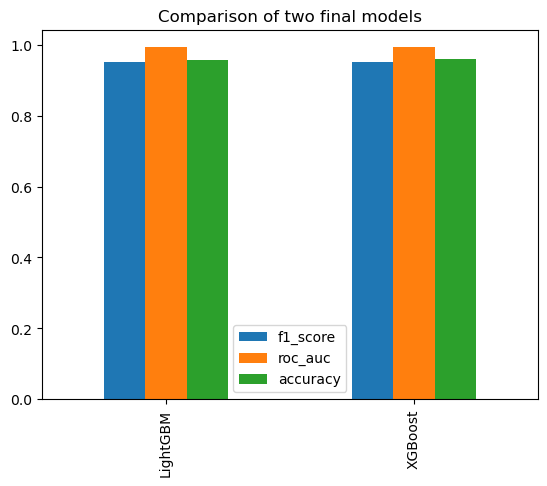

In [ ]:
df3=pd.DataFrame(data=final_Scores,index=["LightGBM","XGBoost"])
df3.plot(kind='bar',title="Comparison of two final models")
plt.show()

# **Conclusion**

After the feature engineering and eda processes of the project, we prepare 9 base models for comparing eachother by f1-score,roc-auc score and accuracy scores. Light-GBM and XGBoost  performed better among base models, the reason why we continued the project with these algorithms despite nearly all of the models reach 0.90+ accuracy,f1,roc-auc scores. The reason behind these scores could be the size of the test set or the new variables that are produced by us. Then, hyperparameter optimizations of XGBoost and Light-GBM were done to find optimal model to predict customer satisfaction. Light-GBM seems a better option to pick because of shorter train times, however if time is not crucial there is no problem for using both algorithms.  